In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn import metrics

# Test/Train Split LSTM

In [245]:
data = pd.read_csv('Google_Stock_Price_Train.csv', date_parser = True)


test_data = data[data['Date'] > '2016-06-01'].copy()

test_data

train_data = data[data['Date'] < '2016-06-01'].copy()



In [246]:
scaler = MinMaxScaler(feature_range=(0,1))

training_data = data.drop(['Date'], axis = 1)
training_data = scaler.fit_transform(training_data)

training_data

array([[0.08581368, 0.09640129, 0.09044931, 0.23757287, 0.29525831],
       [0.09701243, 0.09834351, 0.09823458, 0.24151427, 0.22993592],
       [0.09433366, 0.09251685, 0.09408623, 0.22878051, 0.26361233],
       ...,
       [0.95725128, 0.95807422, 0.95844067, 0.40495845, 0.04589107],
       [0.93796041, 0.94257381, 0.95033338, 0.40184391, 0.02949139],
       [0.93688146, 0.93669113, 0.93421352, 0.38672602, 0.07056868]])

In [247]:
X_train = [] 
y_train = []

training_data.shape[0]

1258

In [248]:
for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60:i])
    y_train.append(training_data[i, 0])
    

In [249]:
X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape, y_train.shape

((1198, 60, 5), (1198,))

In [250]:
reg = Sequential()

reg.add(LSTM(units = 50,return_sequences = True,  input_shape=(X_train.shape[1], 5)))
reg.add(Dropout(0.2))


#Second LSTM Layer
reg.add(LSTM(units = 60, return_sequences = True))
reg.add(Dropout(0.3))

# Third LSTM Layer
reg.add(LSTM(units = 80, return_sequences = True))
reg.add(Dropout(0.4))

# Fourth LSTM Layer
reg.add(LSTM(units = 120))
reg.add(Dropout(0.5))


# The output layer
reg.add(Dense(units = 1))

reg.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 60, 50)            11200     
_________________________________________________________________
dropout_56 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 60, 60)            26640     
_________________________________________________________________
dropout_57 (Dropout)         (None, 60, 60)            0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 60, 80)            45120     
_________________________________________________________________
dropout_58 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_59 (LSTM)               (None, 120)             

In [251]:
reg.compile(optimizer='adam', loss = 'mean_squared_error')

reg.fit(X_train, y_train, epochs=10,batch_size=32)


Epoch 1/10
38/38 [==============================] - 4s 104ms/step - loss: 0.0302
Epoch 2/10
38/38 [==============================] - 4s 101ms/step - loss: 0.0077
Epoch 3/10
38/38 [==============================] - 4s 98ms/step - loss: 0.0072
Epoch 4/10
38/38 [==============================] - 4s 104ms/step - loss: 0.0072
Epoch 5/10
38/38 [==============================] - 4s 95ms/step - loss: 0.0060
Epoch 6/10
38/38 [==============================] - 4s 96ms/step - loss: 0.0063
Epoch 7/10
38/38 [==============================] - 4s 98ms/step - loss: 0.0055
Epoch 8/10
38/38 [==============================] - 4s 113ms/step - loss: 0.0067
Epoch 9/10
38/38 [==============================] - 6s 153ms/step - loss: 0.0055
Epoch 10/10
38/38 [==============================] - 6s 159ms/step - loss: 0.0061


In [252]:
test_data

past_60_days= train_data.tail(60)

df = past_60_days.append(test_data, ignore_index=True)

df = df.drop(['Date'], axis = 1)

In [253]:
inputs = scaler.transform(df)
inputs

array([[0.79578094, 0.79720619, 0.77602667, 0.28107989, 0.11923108],
       [0.76171962, 0.78917586, 0.77307168, 0.27943993, 0.0828354 ],
       [0.78009897, 0.79270547, 0.78947568, 0.29497127, 0.05661193],
       ...,
       [0.95725128, 0.95807422, 0.95844067, 0.40495845, 0.04589107],
       [0.93796041, 0.94257381, 0.95033338, 0.40184391, 0.02949139],
       [0.93688146, 0.93669113, 0.93421352, 0.38672602, 0.07056868]])

In [254]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i,0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

X_test.shape, y_test.shape

((148, 60, 5), (148,))

In [261]:
y_pred = reg.predict(X_test)

scaler.scale_

array([1.86025746e-03, 1.86751825e-03, 1.89422640e-03, 1.37811281e-03,
       4.00480577e-08])

In [262]:
scale = 1/1.86025746e-03
scale

537.5599998937781

# Visualize

In [263]:
y_pred = y_pred*scale
y_test= y_test*scale

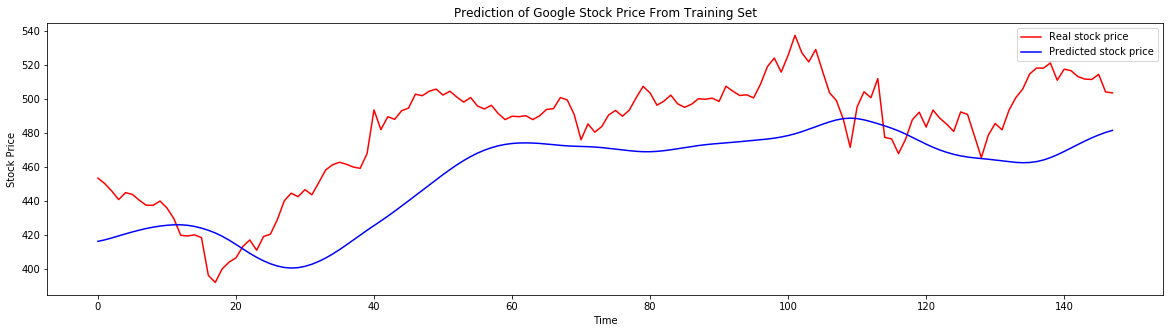

In [265]:
#Visualize Results
plt.figure(figsize=(20,5))
plt.plot(y_test, color='red', label = "Real stock price")
plt.plot(y_pred, color='blue', label = "Predicted stock price")
plt.title("Prediction of Google Stock Price From Training Set")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Run against validation Set

In [312]:
train_data = pd.read_csv('Google_Stock_Price_Train.csv', date_parser = True)
train_data.head()

training_set = train_data.iloc[:,1:2].values

training_set


array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [313]:
scaler = MinMaxScaler(feature_range=(0,1))
train_set_sc = scaler.fit_transform(training_set)



In [314]:
X_train=[]
y_train = []
n=70

for i in range(n,len(train_set_sc)):
    X_train.append(train_set_sc[i-n: i,0])
    y_train.append(train_set_sc[i,0])



In [315]:
X_train, y_train = np.array(X_train), np.array(y_train)



X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#dimension is 3
X_train.shape

(1188, 70, 1)

# LSTM MODEL

In [316]:
reg = Sequential()
reg.add(LSTM(units = 50,return_sequences = True,  input_shape=(X_train.shape[1], 1)))
reg.add(Dropout(0.2))


#Second LSTM Layer
reg.add(LSTM(units = 60, return_sequences = True))
reg.add(Dropout(0.3))

# Third LSTM Layer
reg.add(LSTM(units = 80, return_sequences = True))
reg.add(Dropout(0.4))

# Fourth LSTM Layer
reg.add(LSTM(units = 120))
reg.add(Dropout(0.5))


# The output layer
reg.add(Dense(units = 1))





             

In [317]:
reg.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 70, 50)            10400     
_________________________________________________________________
dropout_76 (Dropout)         (None, 70, 50)            0         
_________________________________________________________________
lstm_77 (LSTM)               (None, 70, 60)            26640     
_________________________________________________________________
dropout_77 (Dropout)         (None, 70, 60)            0         
_________________________________________________________________
lstm_78 (LSTM)               (None, 70, 80)            45120     
_________________________________________________________________
dropout_78 (Dropout)         (None, 70, 80)            0         
_________________________________________________________________
lstm_79 (LSTM)               (None, 120)             

In [318]:
reg.compile(optimizer='adam', loss = 'mean_squared_error')

In [319]:
reg.fit(X_train, y_train, epochs=50,batch_size=32, verbose=1)

Epoch 1/50
38/38 [==============================] - 5s 122ms/step - loss: 0.0393
Epoch 2/50
38/38 [==============================] - 4s 107ms/step - loss: 0.0076
Epoch 3/50
38/38 [==============================] - 5s 119ms/step - loss: 0.0073
Epoch 4/50
38/38 [==============================] - 4s 106ms/step - loss: 0.0085
Epoch 5/50
38/38 [==============================] - 4s 107ms/step - loss: 0.0076
Epoch 6/50
38/38 [==============================] - 4s 102ms/step - loss: 0.0071
Epoch 7/50
38/38 [==============================] - 4s 105ms/step - loss: 0.0076
Epoch 8/50
38/38 [==============================] - 4s 118ms/step - loss: 0.0059
Epoch 9/50
38/38 [==============================] - 4s 109ms/step - loss: 0.0062
Epoch 10/50
38/38 [==============================] - 4s 107ms/step - loss: 0.0055
Epoch 11/50
38/38 [==============================] - 4s 102ms/step - loss: 0.0055
Epoch 12/50
38/38 [==============================] - 4s 102ms/step - loss: 0.0061
Epoch 13/50
38/38 [======

# PREP TEST DATA TO COMPARE

In [320]:
test_data = pd.read_csv("Google_Stock_Price_Test.csv")

test_set = test_data.iloc[:, 1:2].values

In [321]:
data_total = pd.concat((train_data['Open'], test_data['Open']), axis=0)

inputs=data_total[len(train_data) - len(test_data) - 50:].values

inputs= inputs.reshape(-1,1)

inputs = scaler.transform(inputs)


In [322]:
X_test = []
y_test = []
n=70

for i in range(n,inputs.shape[0]):
    X_test.append(inputs[i-n:i,0])


In [323]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))

X_test.shape


(20, 70, 1)

In [324]:
y_pred = reg.predict(X_test)

In [325]:
y_pred = scaler.inverse_transform(y_pred)

# VISUALIZE

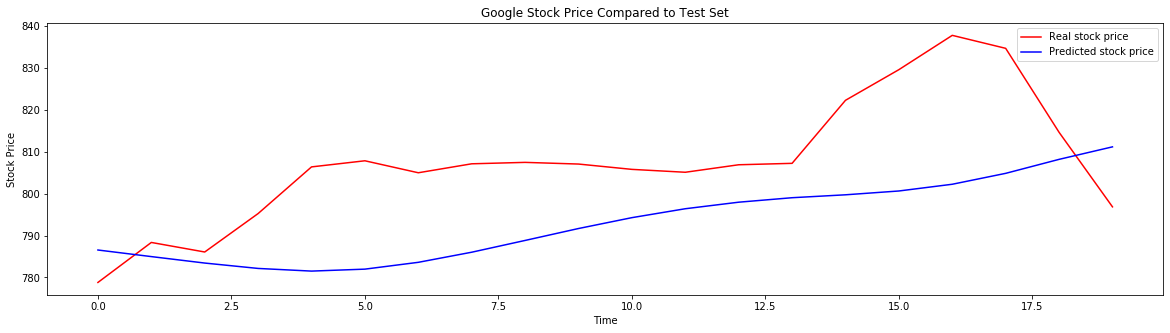

In [326]:
#Visualize Results
plt.figure(figsize=(20,5))
plt.plot(test_set, color='red', label = "Real stock price")
plt.plot(y_pred, color='blue', label = "Predicted stock price")
plt.title("Google Stock Price Compared to Test Set")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Linear Regression

In [289]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [290]:
tr_data = train_data = pd.read_csv('Google_Stock_Price_Train.csv', date_parser = True)
tr_data.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,7380500.0
1,2012-01-04,331.27,333.87,329.08,666.45,5749400.0
2,2012-01-05,329.83,330.75,326.89,657.21,6590300.0
3,2012-01-06,328.34,328.77,323.68,648.24,5405900.0
4,2012-01-09,322.04,322.29,309.46,620.76,11688800.0


In [291]:
tst_data = pd.read_csv('Google_Stock_Price_Test.csv', date_parser = True)
tst_data.head()

,Date,Open,High,Low,Close,Volume
0,2017-01-03,778.81,789.63,775.80,786.14,1657300
1,2017-01-04,788.36,791.34,783.16,786.90,1073000
2,2017-01-05,786.08,794.48,785.02,794.02,1335200
3,2017-01-06,795.26,807.90,792.20,806.15,1640200
4,2017-01-09,806.40,809.97,802.83,806.65,1272400


In [292]:
x_tr = tr_data[['Open','High', 'Low', 'Volume']].values
y_tr = tr_data['Close'].values

In [293]:
x_tst = tst_data[['Open','High', 'Low', 'Volume']].values
y_tst = tst_data['Close'].values

In [294]:
x_train, y_train = x_tr, y_tr
x_test, y_test = x_tst, y_tst

In [295]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [296]:
predicted = regressor.predict(x_test)
print(predicted)

[754.40588319 798.71235287 795.07824942 743.57927405 829.4820455
 842.971888   824.66560288 819.38288804 853.16453882 836.00568628
 850.32137505 809.50764    865.09686812 747.53742228 836.37799812
 813.03267399 868.59517571 750.37950626 807.90366731 817.04218114]


In [297]:
dframe = pd.DataFrame({'Actual':y_test.flatten(), 'Predicted':predicted.flatten()})
dframe.head(20)

,Actual,Predicted
0,786.14,754.405883
1,786.90,798.712353
2,794.02,795.078249
3,806.15,743.579274
4,806.65,829.482045
5,804.79,842.971888
6,807.91,824.665603
7,806.36,819.382888
8,807.88,853.164539
9,804.61,836.005686


In [298]:
import math

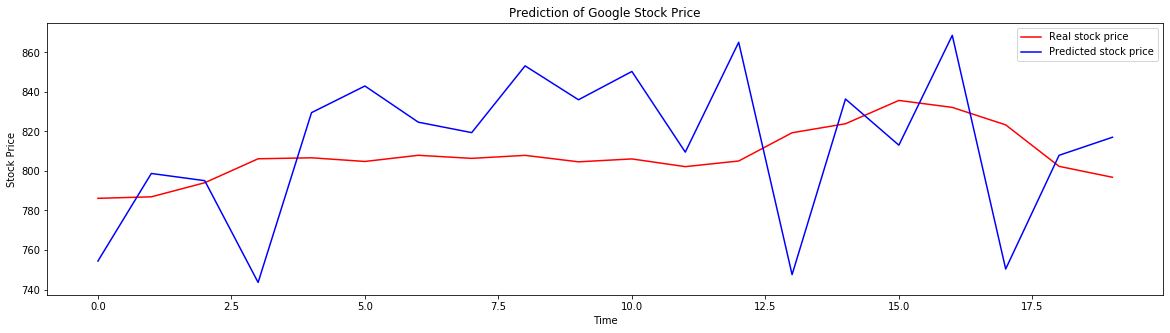

In [299]:
plt.figure(figsize=(20,5))
plt.plot(y_test, color='red', label = "Real stock price")
plt.plot(predicted, color='blue', label = "Predicted stock price")
plt.title("Prediction of Google Stock Price")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()